# Trabajo Detección de Anomalías.

Sergio Conde Sánchez

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Dense, Dropout

## Preprocesado de datos

In [ ]:
data = pd.read_csv('PHL-EC.csv')
data

,P. Name,P. Name Kepler,P. Name KOI,P. Zone Class,P. Mass Class,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Min Mass (EU),P. Mass (EU),...,P. Int ESI,P. Surf ESI,P. ESI,S. HabCat,P. Habitable,P. Hab Moon,P. Confirmed,P. Disc. Method,P. Disc. Year,Unnamed: 68
0,1RXS 1609 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4451.16,...,0,0,0.05,0,0,0,1,Imaging,2008,NaN
1,1SWASP J1407 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,6358.80,...,0,0,0.07,0,0,0,1,Primary Transit,2012,NaN
2,2M 0103-55(AB) b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,4133.22,4133.22,...,0,0,0.06,0,0,0,1,Imaging,2013,NaN
3,2M 0122-24 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,6358.80,...,0,0,0.08,0,0,0,1,Imaging,2013,NaN
4,2M 0219-39 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4419.37,...,0,0,0.06,0,0,0,1,Imaging,2015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3870,YBP1194 b,NaN,NaN,Hot,Jovian,gas,metals-rich,non-habitable,108.10,108.10,...,0,0,0.16,0,0,0,1,Radial Velocity,2014,NaN
3871,YBP1514 b,NaN,NaN,Hot,Jovian,gas,metals-rich,non-habitable,127.18,127.18,...,0,0,0.15,0,0,0,1,Radial Velocity,2014,NaN
3872,YZ Cet b,NaN,NaN,Hot,Terran,rocky-iron,metals-rich,non-habitable,0.76,0.76,...,0,0,0.43,0,0,0,1,Radial Velocity,2017,NaN
3873,YZ Cet c,NaN,NaN,Hot,Terran,rocky-iron,metals-rich,non-habitable,0.99,0.99,...,0,0,0.53,0,0,0,1,Radial Velocity,2017,NaN


Nos quedamos solo con las columnas que contengan al menos 1600 elementos no nulos.

In [ ]:
df = data.copy().dropna(thresh = 1600, axis = 1)
df.columns

Index(['P. Name', 'P. Name Kepler', 'P. Zone Class', 'P. Mass Class',
       'P. Composition Class', 'P. Atmosphere Class', 'P. Habitable Class',
       'P. Mass (EU)', 'P. Radius (EU)', 'P. Density (EU)', 'P. Gravity (EU)',
       'P. Esc Vel (EU)', 'P. SFlux Min (EU)', 'P. SFlux Mean (EU)',
       'P. SFlux Max (EU)', 'P. Teq Min (K)', 'P. Teq Mean (K)',
       'P. Teq Max (K)', 'P. Ts Min (K)', 'P. Ts Mean (K)', 'P. Ts Max (K)',
       'P. Surf Press (EU)', 'P. Mag', 'P. Appar Size (deg)',
       'P. Period (days)', 'P. Sem Major Axis (AU)', 'P. Eccentricity',
       'P. Mean Distance (AU)', 'P. Omega (deg)', 'S. Name',
       'S. Constellation', 'S. Type', 'S. Mass (SU)', 'S. Radius (SU)',
       'S. Teff (K)', 'S. Luminosity (SU)', 'S. [Fe/H]', 'S. Age (Gyrs)',
       'S. Appar Mag', 'S. Distance (pc)', 'S. RA (hrs)', 'S. DEC (deg)',
       'S. Mag from Planet', 'S. Size from Planet (deg)', 'S. No. Planets',
       'S. No. Planets HZ', 'S. Hab Zone Min (AU)', 'S. Hab Zone Max (AU)

Vamos a ver qué variables del dataset no son numéricas

In [ ]:
df.dtypes[df.dtypes == object]

P. Name                 object
P. Name Kepler          object
P. Zone Class           object
P. Mass Class           object
P. Composition Class    object
P. Atmosphere Class     object
P. Habitable Class      object
P. SFlux Min (EU)       object
P. SFlux Mean (EU)      object
P. SFlux Max (EU)       object
S. Name                 object
S. Constellation        object
S. Type                 object
P. Disc. Method         object
P. Disc. Year           object
dtype: object

Como las variables de flujo deben ser numéricas, hacemos el cambio:

In [ ]:
df["P. SFlux Min (EU)"] = pd.to_numeric(df["P. SFlux Min (EU)"],errors='coerce')
df["P. SFlux Mean (EU)"] = pd.to_numeric(df["P. SFlux Mean (EU)"],errors='coerce')
df["P. SFlux Max (EU)"] = pd.to_numeric(df["P. SFlux Max (EU)"],errors='coerce')

Ahora sí, excluimos todas las variables que no sean numericas:

In [ ]:
df = df.select_dtypes(exclude=[object])

A pesarde haber eliminado las variables tipo objeto, podemos ver que varias de ellas sí presentan características importantes de cada planeta, como la atmosfera o su composición. Por ello, codificaremos dichas variables con one hot encoding.

In [ ]:
# Añadimos dos columnas como factores haciendo one hot encoding
y1 = pd.get_dummies(data['P. Atmosphere Class'], prefix='Atmos')
y2 = pd.get_dummies(data['P. Zone Class'], prefix='Zone')
y3 = pd.get_dummies(data['P. Mass Class'], prefix='Mass')
y4 = pd.get_dummies(data['P. Composition Class'], prefix='Comp')
df = pd.concat([df, y1, y2, y3, y4], axis=1)

In [ ]:
df.shape

(3875, 67)

A continuación, trataremos de seleccionar aquellas variables que nos sirven para diferenciar entre ambas etiquetas. Para ello, haremos un boxplot para cada variable y trataremos de buscar aquellas que presentan un distribución diferenciada para cada una de las etiquetas.

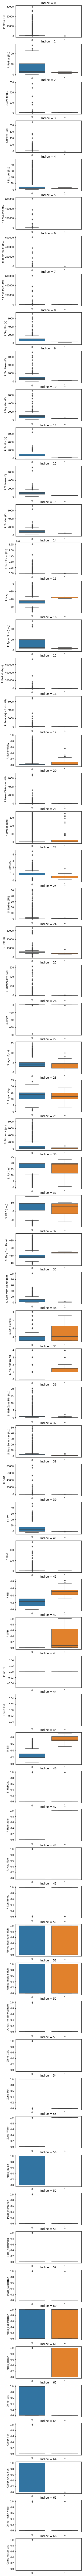

In [ ]:
#fig, axes = plt.subplots(56, 1, figsize=(5, 200))
#for i in range(56):
#  sns.scatterplot(data=df,x = range(df.shape[0]), y=df.iloc[:,i], hue = 'P. Habitable', ax = axes[i])

fig, axes = plt.subplots(len(df.columns), 1, figsize=(5, 200))
for i in range(len(df.columns)):
    sns.boxplot(data = df, y=df.iloc[:,i], x = 'P. Habitable', ax = axes[i]).set(xlabel= None, title = 'Indice = {}'.format(i))
plt.show()

In [ ]:
#seleccionamos las columnas
df = df.iloc[:, [1,9, 12, 15, 16, 22, 23, 24, 32, 33, 34, 35, 39, 41, 42, 45, 54, 55, 56, 61,62, 64, 47]]

Vamos a comprobar si hay datos faltantes:

In [ ]:
print(
df.isna().sum()
)

P. Radius (EU)                 12
P. Teq Mean (K)                46
P. Ts Mean (K)               2126
P. Mag                         56
P. Appar Size (deg)            12
S. Mass (SU)                   47
S. Radius (SU)                112
S. Teff (K)                    99
S. Mag from Planet             46
S. Size from Planet (deg)     128
S. No. Planets                  0
S. No. Planets HZ               0
P. HZC                         41
P. HZI                         85
P. SPH                       2074
P. ESI                         48
Zone_Hot                        0
Zone_Warm                       0
Mass_Jovian                     0
Mass_Terran                     0
Comp_gas                        0
Comp_rocky-iron                 0
P. Habitable                    0
dtype: int64


como no tiene mucho sentido imputar valores de variales con tantos NaN, vamos a prescindir de ellos, ya que aún así, tenemos suficientes para nuestro problema.

In [ ]:
df = df.dropna().reset_index(drop=True)
df

,P. Radius (EU),P. Teq Mean (K),P. Ts Mean (K),P. Mag,P. Appar Size (deg),S. Mass (SU),S. Radius (SU),S. Teff (K),S. Mag from Planet,S. Size from Planet (deg),...,P. HZI,P. SPH,P. ESI,Zone_Hot,Zone_Warm,Mass_Jovian,Mass_Terran,Comp_gas,Comp_rocky-iron,P. Habitable
0,1.99,1790.4,1833.5,-27.18,3.78,0.91,0.94,5196.0,-35.2,33.0178,...,0.28,0.00,0.26,1,0,0,0,0,0,0
1,1.66,1054.4,1095.7,-24.50,3.16,0.95,0.94,5531.0,-32.9,10.0643,...,0.29,0.00,0.27,1,0,0,0,0,1,0
2,1.09,1068.0,1102.1,-23.61,2.06,0.93,0.86,5214.0,-33.0,11.5197,...,0.28,0.00,0.30,1,0,0,1,0,1,0
3,2.23,498.9,546.5,-21.85,4.24,0.96,0.93,5766.0,-29.7,2.0522,...,0.33,0.00,0.33,1,0,0,0,0,1,0
4,1.91,1177.4,1221.5,-25.27,3.63,0.70,1.64,4324.0,-33.4,20.5046,...,0.30,0.00,0.26,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,1.49,276.4,315.8,-18.42,2.83,0.25,0.32,3305.0,-27.1,1.9321,...,0.51,0.17,0.82,0,1,0,1,0,1,1
1737,1.86,117.9,161.4,-15.65,3.53,0.25,0.32,3305.0,-23.9,0.4354,...,0.16,0.00,0.33,0,0,0,0,0,1,0
1738,0.96,442.6,474.8,-19.50,1.83,0.13,0.17,3056.0,-29.1,5.7526,...,0.34,0.00,0.43,1,0,0,1,0,1,0
1739,1.04,382.0,415.4,-19.03,1.97,0.13,0.17,3056.0,-28.5,4.2882,...,0.36,0.00,0.53,1,0,0,1,0,1,0


A continuación, crearemos nuestros sets de train y test, pero antes, separaremos la columna de etiquetas de nuestro dataset original, que en nuestro caso es la columna P. Habitable. Por último, hacemos min max scale con los datos

In [ ]:
raw_data = df.drop('P. Habitable', axis = 1).values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = df['P. Habitable'].values
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.3, random_state=123
)

scaler = MinMaxScaler(feature_range=(0, 1))

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Ahora, separaremos los datos en función de su etiqueta, para entrenar el autoencoder solo con datos normales. Para ello, seleccionaremos todos los datos etiquetados como *non-habitable* como normales y el resto como anómalos. Es importante notar que se trata de un dataset altamente desbalanceado, pero esto no es un problema para los autoencoders.

In [ ]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

#creating normal and anomaly datasets normal = 0, anomaly = 1
x_train_normal = x_train[~y_train]
x_test_normal = x_test[~y_test]
x_train_anom = x_train[y_train]
x_test_anom = x_test[y_test]

print(" No. of records in Fraud Train Data=",len(x_train_anom))
print(" No. of records in Normal Train data=",len(x_train_normal))
print(" No. of records in Fraud Test Data=",len(x_test_anom))
print(" No. of records in Normal Test data=",len(x_test_normal))

 No. of records in Fraud Train Data= 37
 No. of records in Normal Train data= 1181
 No. of records in Fraud Test Data= 18
 No. of records in Normal Test data= 505


## PCA + AutAD

Comenzaremos con el primer método, haciendo PCA y quedándonos con 10 características para más tarde crear un autoencoder que nos sirva para detectar los planetas no habitables. Para esto, debemos hacer el fit de la pca con todos los datos de entrenamiento, y con ese modelo, transformar tanto los datos de entrenamiento como los de test. Una vez hecho eso, ya se puede separar en anómalos y normales.

In [ ]:
pca = PCA(n_components=10)
pca_train = pca.fit_transform(x_train)
pca_test = pca.transform(x_test)

#min max scale
pca_scaler = MinMaxScaler(feature_range=(0, 1))
pca_train = pca_scaler.fit_transform(pca_train)
pca_test = pca_scaler.transform(pca_test)

pca_train_normal = pca_train[~y_train]
pca_test_normal = pca_test[~y_test]
pca_train_anom = pca_train[y_train]
pca_test_anom = pca_test[y_test]

Creamos el autoencoder que vamos a utilizar

In [ ]:
dimension_entrada = 10
dimension_codificacion = 2



entrada = Input(shape=(dimension_entrada,))
encoded = Dense(36, activation='relu')(entrada)
encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(8, activation='relu')(encoded)

encoded = Dense(dimension_codificacion, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)

decoded= Dropout(0.2)(decoded)
decoded = Dense(16, activation='relu')(decoded)
decoded= Dropout(0.2)(decoded)
decoded = Dense(36, activation='relu')(decoded)

decodificada = Dense(dimension_entrada, activation='sigmoid')(decoded)

autoAD = Model(entrada,decodificada) 
autoAD.compile(optimizer=  'adam' ,loss = 'mse', metrics = ['accuracy'])

autoAD.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_246 (Dense)           (None, 36)                396       
                                                                 
 dropout_74 (Dropout)        (None, 36)                0         
                                                                 
 dense_247 (Dense)           (None, 16)                592       
                                                                 
 dropout_75 (Dropout)        (None, 16)                0         
                                                                 
 dense_248 (Dense)           (None, 8)                 136       
                                                                 
 dense_249 (Dense)           (None, 2)                 18 

Entrenamos el modelo:

In [ ]:
autoAD.compile(loss='mse', metrics=['accuracy'], optimizer='adam')

history = autoAD.fit(
    pca_train_normal,
    pca_train_normal,
    epochs=150,
    batch_size=512,
    validation_data=(pca_test_normal, pca_test_normal),
    shuffle=True)

Epoch 1/150
3/3 [==============================] - 1s 115ms/step - loss: 0.0442 - accuracy: 0.3472 - val_loss: 0.0441 - val_accuracy: 0.3703
Epoch 2/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0438 - accuracy: 0.3404 - val_loss: 0.0436 - val_accuracy: 0.4832
Epoch 3/150
3/3 [==============================] - 0s 17ms/step - loss: 0.0432 - accuracy: 0.3819 - val_loss: 0.0430 - val_accuracy: 0.4733
Epoch 4/150
3/3 [==============================] - 0s 18ms/step - loss: 0.0426 - accuracy: 0.3599 - val_loss: 0.0422 - val_accuracy: 0.1703
Epoch 5/150
3/3 [==============================] - 0s 18ms/step - loss: 0.0418 - accuracy: 0.3099 - val_loss: 0.0412 - val_accuracy: 0.1446
Epoch 6/150
3/3 [==============================] - 0s 18ms/step - loss: 0.0408 - accuracy: 0.2701 - val_loss: 0.0401 - val_accuracy: 0.1446
Epoch 7/150
3/3 [==============================] - 0s 18ms/step - loss: 0.0397 - accuracy: 0.2540 - val_loss: 0.0388 - val_accuracy: 0.1446
Epoch 8/150
3/3 [==

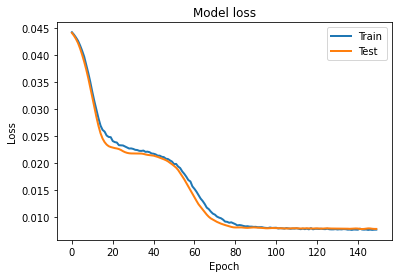

In [ ]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

Vamos ahora a definir una funcion que nos ayude a determinar un threshold para nuestros resultados. Para ello, propondremos como threshold la media del error de reconstrucción de todas las muestras más su desviación estándar (en este apartado usaremos el doble de la desviación estándar porque nos separa mejor los datos).

In [ ]:
def find_threshold_PCA(model, x_train):
  reconstructions = model.predict(x_train)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + 2*np.std(reconstruction_errors.numpy())
  return threshold

In [ ]:
test_x_predictions = autoAD.predict(pca_test)
mse = tf.keras.losses.mse(pca_test, test_x_predictions)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})

Representaremos los datos y el threshold para ver gráficamenrte la separación del modelo.

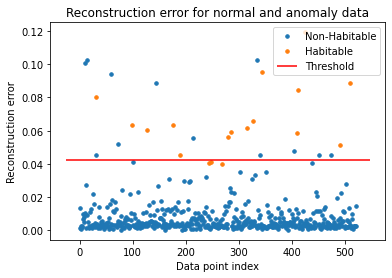

In [ ]:
threshold_fixed = find_threshold_PCA(autoAD, pca_test)
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Habitable" if name == 1 else "Non-Habitable")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and anomaly data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

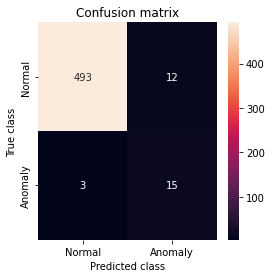

 Accuracy:  0.97131931166348
 Recall:  0.8333333333333334
 Precision:  0.5555555555555556


In [ ]:
LABELS = ["Normal","Anomaly"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

Vemos que con este modelo se obtiene un buen recall, pero una precisión muy baja. Esto se puede ver más claro en la gráfica anterior, y significa que efectivamente los planetas habitables tienen un error de reconstrucción mucho más alto que la media de los no habitables, pero también hay una gran cantidad de planetas no habitables con un error de reconstrucción igual de alto.

 ## autRD+autAD

En este apartado, construiremos dos autoencoders. Uno para reducir la dimensionalidad (en nuestro caso lo reduciremos a 10 dimensiones) y otro para detectar los planetas habitables. 
Comenzamos construyendo el autoencoder que nos reducirá la dimensionalidad, autoRD:

In [ ]:
dimension_entrada = x_train.shape[1]
dimension_codificacion = 10

#definimos la estructura
entrada = Input(shape = (dimension_entrada))
codificada = Dense(32, activation = 'relu')(entrada)
codificada = Dropout(0.2)(codificada)
codificada = Dense(16, activation = 'relu')(codificada)
codificada = Dropout(0.2)(codificada)
codificada = Dense(dimension_codificacion, activation = 'relu')(codificada)
decodificada = Dense(16, activation = 'relu')(codificada)
decodificada = Dropout(0.2)(decodificada)
decodificada = Dense(32, activation = 'relu')(decodificada)
decodificada = Dropout(0.2)(decodificada)
decodificada = Dense(dimension_entrada, activation = 'sigmoid')(decodificada)
autoencoder = Model(entrada, decodificada)
autoencoder.compile(optimizer = 'adam', loss = 'mse', metrics='accuracy')


autoencoder.summary()
# lo entrenamos
history = autoencoder.fit(x_train, x_train, epochs=150, batch_size=256)


Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 21)]              0         
                                                                 
 dense_349 (Dense)           (None, 32)                704       
                                                                 
 dropout_99 (Dropout)        (None, 32)                0         
                                                                 
 dense_350 (Dense)           (None, 16)                528       
                                                                 
 dropout_100 (Dropout)       (None, 16)                0         
                                                                 
 dense_351 (Dense)           (None, 10)                170       
                                                                 
 dense_352 (Dense)           (None, 16)                176

Una vez entrenado el autoRD, haremos las transformaciones necesarias para obtener nuestros nuevos datasets de entrenamiento y normales transformados, de un modo similar al que hicimos con la PCA:

In [ ]:
#Realizamos la codificacion
autoRD = Model(entrada, codificada)

autoRD.summary()

RD_train = autoRD.predict(x_train) #codificados
RD_test = autoRD.predict(x_test) #decodificados

#Separaomos segun las etiquetas
RD_train_normal = RD_train[~y_train]
RD_test_normal = RD_test[~y_test]
RD_train_anom = RD_train[y_train]
RD_test_anom = RD_test[y_test]

Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 21)]              0         
                                                                 
 dense_349 (Dense)           (None, 32)                704       
                                                                 
 dropout_99 (Dropout)        (None, 32)                0         
                                                                 
 dense_350 (Dense)           (None, 16)                528       
                                                                 
 dropout_100 (Dropout)       (None, 16)                0         
                                                                 
 dense_351 (Dense)           (None, 10)                170       
                                                                 
Total params: 1,402
Trainable params: 1,402
Non-trainable 

Para el autoencoder de clasficiacion, emplearemos un estructura muy similar a la utilizada en la PCA.

In [ ]:
dimension_entrada = 10
dimension_codificacion = 4



entrada = Input(shape=(dimension_entrada,))
encoded = Dense(64, activation='relu')(entrada)

encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation='relu')(encoded)

encoded = Dense(dimension_codificacion, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(decoded)
decoded= Dropout(0.2)(decoded)
decoded = Dense(64, activation='relu')(decoded)

decodificada = Dense(dimension_entrada, activation='sigmoid')(decoded)

autoencoder = Model(entrada,decodificada) 
autoencoder.compile(optimizer=  'adam' ,loss = 'mse', metrics = ['accuracy'])

autoencoder.summary()


Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_355 (Dense)           (None, 64)                704       
                                                                 
 dense_356 (Dense)           (None, 32)                2080      
                                                                 
 dropout_103 (Dropout)       (None, 32)                0         
                                                                 
 dense_357 (Dense)           (None, 16)                528       
                                                                 
 dense_358 (Dense)           (None, 4)                 68        
                                                                 
 dense_359 (Dense)           (None, 16)                80 

In [ ]:
history = autoencoder.fit(
    RD_train_normal,
    RD_train_normal,
    epochs=80,
    batch_size=36,
    validation_data=(RD_test_normal, RD_test_normal),
    shuffle=True)

Epoch 1/80
33/33 [==============================] - 1s 10ms/step - loss: 0.1468 - accuracy: 0.4733 - val_loss: 0.1072 - val_accuracy: 0.6990
Epoch 2/80
33/33 [==============================] - 0s 4ms/step - loss: 0.0728 - accuracy: 0.5004 - val_loss: 0.0381 - val_accuracy: 0.7089
Epoch 3/80
33/33 [==============================] - 0s 4ms/step - loss: 0.0408 - accuracy: 0.6579 - val_loss: 0.0344 - val_accuracy: 0.7089
Epoch 4/80
33/33 [==============================] - 0s 5ms/step - loss: 0.0378 - accuracy: 0.6681 - val_loss: 0.0327 - val_accuracy: 0.7089
Epoch 5/80
33/33 [==============================] - 0s 4ms/step - loss: 0.0350 - accuracy: 0.6638 - val_loss: 0.0267 - val_accuracy: 0.7089
Epoch 6/80
33/33 [==============================] - 0s 4ms/step - loss: 0.0273 - accuracy: 0.6630 - val_loss: 0.0181 - val_accuracy: 0.7089
Epoch 7/80
33/33 [==============================] - 0s 4ms/step - loss: 0.0210 - accuracy: 0.6655 - val_loss: 0.0151 - val_accuracy: 0.7149
Epoch 8/80
33/33 [=

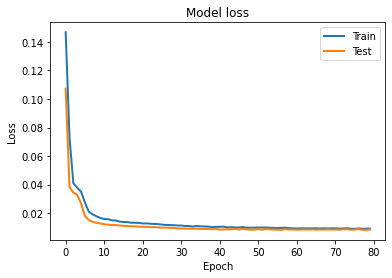

In [ ]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
test_x_predictions = autoencoder.predict(RD_test)
mse = tf.keras.losses.mse(RD_test, test_x_predictions)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})

In [ ]:
def find_threshold_RD(model, x_train):
  reconstructions = model.predict(x_train)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + 2.5*np.std(reconstruction_errors.numpy())
  return threshold

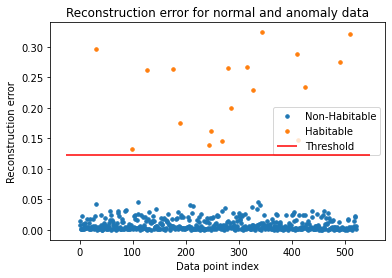

In [ ]:
threshold_fixed = find_threshold_RD(autoencoder, RD_test)
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Habitable" if name == 1 else "Non-Habitable")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and anomaly data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

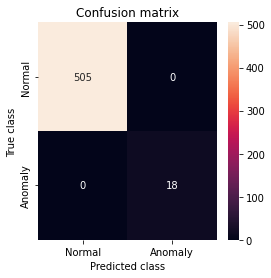

 Accuracy:  1.0
 Recall:  1.0
 Precision:  1.0


In [ ]:
LABELS = ["Normal","Anomaly"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

Con este método conseguimos una separación perfecta entre ambos grupos.

## autTO


Por último, utilizaremos un autoencoder con los datos originales, sin transformar y compararemos los tres métodos.

In [ ]:
input_dim = x_train_normal.shape[1]
encoding_dim = 32
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2= 10
learning_rate = 1e-7

#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="relu", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 21)]              0         
                                                                 
 dense_363 (Dense)           (None, 32)                704       
                                                                 
 dropout_105 (Dropout)       (None, 32)                0         
                                                                 
 dense_364 (Dense)           (None, 16)                528       
                                                                 
 dense_365 (Dense)           (None, 10)                170       
                                                                 
 dense_366 (Dense)           (None, 16)                176       
                                                                 
 dense_367 (Dense)           (None, 32)                544

In [ ]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

history = autoencoder.fit(x_train_normal, x_train_normal,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test)
                    ).history

Epoch 1/200
5/5 [==============================] - 1s 53ms/step - loss: 0.1345 - accuracy: 8.4674e-04 - val_loss: 0.1306 - val_accuracy: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1289 - accuracy: 0.0093 - val_loss: 0.1252 - val_accuracy: 0.0000e+00
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1233 - accuracy: 0.0491 - val_loss: 0.1192 - val_accuracy: 0.0038
Epoch 4/200
5/5 [==============================] - 0s 14ms/step - loss: 0.1165 - accuracy: 0.1211 - val_loss: 0.1110 - val_accuracy: 0.2734
Epoch 5/200
5/5 [==============================] - 0s 14ms/step - loss: 0.1078 - accuracy: 0.2828 - val_loss: 0.1000 - val_accuracy: 0.8910
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0958 - accuracy: 0.5207 - val_loss: 0.0863 - val_accuracy: 0.9407
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0823 - accuracy: 0.6359 - val_loss: 0.0711 - val_accuracy: 0.9407
Epoch 8/

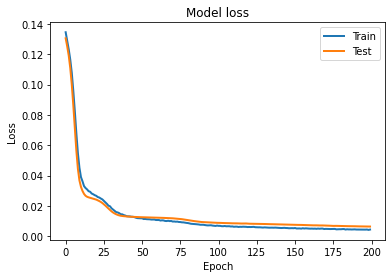

In [ ]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
def find_threshold_Tot(model, x_train):
  reconstructions = model.predict(x_train)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + 2.5*np.std(reconstruction_errors.numpy())
  return threshold

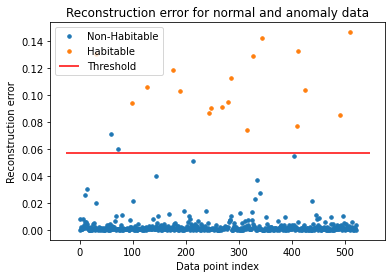

In [ ]:
test_x_predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})

threshold_fixed = find_threshold_Tot(autoencoder, x_test)
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Habitable" if name == 1 else "Non-Habitable")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and anomaly data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

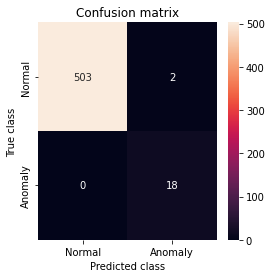

 Accuracy:  0.9961759082217974
 Recall:  1.0
 Precision:  0.9


In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

Por último, utilizando los datos si reducción de dimensionalidad nos equivocamos tan sólo con dos planetas no habitables que clasificamos como habitables.

## Conclusiones.

Hemos visto entonces que el uso de autoencoders para la detección de anomalías da muy buenos resultados, al no presentar problemas con dataset desbalanceados. 

Además, se ha observado el mejor rendimiento que nos da la reducción de dimensionalidad con autoencoders frente a otro método como la PCA. Esto ocurre porque la PCA solo funciona con relaciones lineales entre variables, mientras que nuestro autoencoder es capaz de preservar las separaciones entre grupos de datos en espacios no lineales. 

Por último, aunque los resultados con RD+Autoencoder fueron los mejores, es importante decir que los que obtuvimos sin reducción de dimensionalidad no se alejan mucho.